In [1]:
include("src/SimFunctions.jl")
include("src/PlotFunctions.jl")
using Profile

  Activating project at `~/gh/spinon-calc`


In [2]:
using BenchmarkTools
q = @SVector [0.,0,0]
p = @SVector [1.,2.,3.]

3-element SVector{3, Float64} with indices SOneTo(3):
 1.0
 2.0
 3.0

In [3]:
G = @SMatrix [0. 0. 0.;
	 0. 0. 0.;
	 1. 0. 0.]
k_density_spinon_dispersion = 30
k_density_specweight=10


path_spinons = generate_path(geom.high_symmetry_points, 
	    split("\\Gamma X W K \\Gamma L U W"), 
		points_per_unit=k_density_spinon_dispersion, K_units=2π/8)
	
path = generate_path(geom.high_symmetry_points, 
	    split("\\Gamma X W K \\Gamma L U W"),
		points_per_unit=k_density_specweight, K_units=4π/8)


data_dir = "tmp"

"tmp"

In [4]:
# α should be a 3 x 4 matrix such that 
# A_μ (I_i e_i ) = I_i α_iμ
function construct_landau_gauge(lattice::geom.PyroPrimitive, α)
    A_tet_sites = geom.A_sites(lattice)
    
    A = zeros(Float64, length(A_tet_sites),4)
    for (J, tA) in enumerate(A_tet_sites)
        I, _ = geom.tetra_IDX(lattice, tA) # The three-tuple that does the thing
        A[J,:] = I' * α
    end
    # consistency
    println(exp.(1im* lat.L'*α))
    # @assert all(abs.(exp.(1im* lat.L'*α) .- 1.) .< 1e-10)
    return A
end

construct_landau_gauge (generic function with 1 method)

In [5]:
# 0 flux
sim = SimulationParameters("TEST-0flux", 
    lattice=geom.PyroPrimitive(1,1,1),
    A=[0 0 0 0],
    Jpm = -0.04,
    B=[0,0,0]
    )
λ = calc_lambda(sim)

0.13557337166270977

In [6]:
@benchmark SpinonStructure.calc_xxz_hopping_fast(sim

LoadError: ParseError:
[90m# Error @ [0;0m]8;;file:///Users/alaricsanders/gh/spinon-calc/In[6]#1:53\[90mIn[6]:1:53[0;0m]8;;\
@benchmark SpinonStructure.calc_xxz_hopping_fast(sim[48;2;120;70;70m[0;0m
[90m#                                                   └ ── [0;0m[91mExpected `)`[0;0m

In [7]:
lat = geom.PyroPrimitive(2,2,1)
calc_fluxes(lat, construct_landau_gauge(lat, [π 0 π 0; π 0 0 0; 0 0 0 0]))

ComplexF64[1.0 - 4.898587196589413e-16im 1.0 - 0.0im 1.0 - 2.4492935982947064e-16im 1.0 - 0.0im]


4×4 Matrix{Float64}:
  3.14159   3.14159  -3.14159  -3.14159
  3.14159  -3.14159  -3.14159   3.14159
 -3.14159   3.14159   3.14159  -3.14159
 -3.14159  -3.14159   3.14159   3.14159

In [8]:
# pipi00 flux
sim = SimulationParameters("TEST-pipi00", 
    lattice=geom.PyroPrimitive(1,2,1),
    A=[π 0 0 0; 0 π 0 0],
    Jpm = -0.04,
    B=[0.02,0.02,0]
    )
λ = calc_lambda(sim)

0.1337216394034722

In [9]:
# pi-flux
lat = geom.PyroPrimitive(2,2,1)
A_piflux = construct_landau_gauge(lat, [0 0 0 π; 0 π 0 π; 0 0 0 0])
calc_fluxes(lat, A_piflux)


ComplexF64[1.0 - 0.0im 1.0 - 2.4492935982947064e-16im 1.0 - 0.0im 1.0 - 4.898587196589413e-16im]


4×4 Matrix{Float64}:
 -3.14159  -3.14159   3.14159   3.14159
 -3.14159   3.14159   3.14159  -3.14159
  3.14159  -3.14159  -3.14159   3.14159
  3.14159   3.14159  -3.14159  -3.14159

Plotting spinon dispersions...


Spinon Dispersion: 100%|████████████████████████████████| Time: 0:00:00


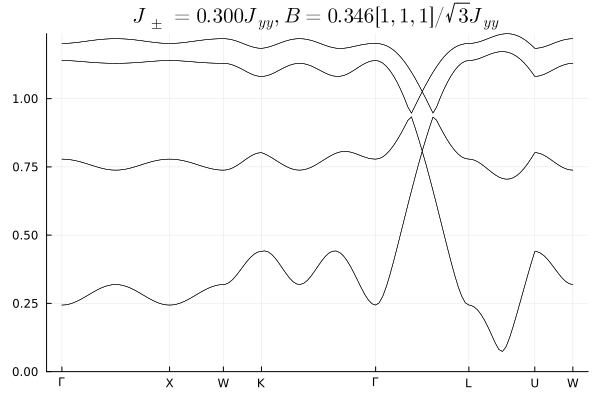

In [10]:
println("Plotting spinon dispersions...")


sim = SimulationParameters("TEST-piflux", 
    lattice=lat,
    A=A_piflux,
    Jpm = 0.3,
    B=[0.2,0.2,0.2]
    )
λ = calc_lambda(sim)
# compute spinons
d = calc_spinons_along_path(data_dir, sim=sim, λ=λ, path=path_spinons)
	
p = plot_spinons(load(d))


In [11]:

	# autorange this based on the spinon dispersion
max_E = 2.2* maximum( load(d)["spinon_dispersion"]["bands"] )
Egrid = collect(range(0,max_E,150)); # TODO consider updating this based on broadening_dE
datafiles = []

Any[]

In [12]:
length(sim.lat.tetra_sites)

8

In [ ]:

@benchmark spectral_weight(q, collect(range(0.,4.,50)), sim, λ, integration_settings["fast"])


In [ ]:
@benchmark spectral_weight(q, collect(range(0.,4.,50)), sim, λ, integration_settings["slow"])


In [ ]:
Profile.clear()

f = @profile calc_spectral_weight_along_path(data_dir, 
	    sim=sim,
        λ=λ,
	    ip=integration_settings["very_fast"], 
	    Egrid=Egrid, path=path, g_tensor=G)
	    # f = data_dir*"/SQW"*sim_identifier(sim)*".jld"

push!(datafiles, f)
println("Saving data to ",f)


In [ ]:
data = load(f)

In [ ]:
heatmap(real(data["intensity"]["Spm"])')

In [ ]:
heatmap(imag(data["intensity"]["Spm"])')

In [ ]:
heatmap(real(data["intensity"]["Spp"])')

In [ ]:
heatmap(imag(data["intensity"]["Spp"])')

In [ ]:


# Profile.clear()


@benchmark corr_at(q, p, sim, λ, SMatrix{3,3}([1. 0 0; 0 1 0; 0 0 1])) 


In [ ]:
@benchmark corr_at(q, p, sim, λ, nothing)

In [ ]:
Profile.clear()
@profile [corr_at(q, p, sim, λ) for _ in 1:100]

Profile.print()

In [ ]:
using ProfileView

ProfileView.view()

In [ ]:
@benchmark spinon_dispersion(q, sim, λ)


In [ ]:
@benchmark geom.tetra_idx(sim.lat, SVector{3}([0,0,0]))

In [ ]:



data = load(f)
sim_x = SimulationParameters(data["physical_parameters"])
	
p = plot_spectral_weight(data,"Spm")
# savefig(p, figure_dir*"corr_S+-"*sim_identifier(sim_x)*".pdf")
	
	

In [ ]:

	    # p = plot_spectral_weight(data,"Spp")
	    # savefig(p, figure_dir*"corr_S++"*sim_identifier(sim_x)*".pdf")
	
	
p = plot_spectral_weight(data,"Smagnetic")
# savefig(p, figure_dir*"corr_Smagnetic"*sim_identifier(sim_x)*".pdf")